# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3631.671657,1.0000,-131.886217,1446.74,1314.853783
OMUSDT,526.319895,1655.565242,0.4559,0.000000,1129.25,1129.250000
BTCUSDT,601.021649,839.193167,0.2311,3.537078,238.17,241.707078
SOLUSDT,281.200518,422.347623,0.1163,0.000000,141.15,141.150000
JASMYUSDT,387.458505,321.741481,0.0886,0.000000,-65.72,-65.720000
ETHUSDT,250.747339,246.721614,0.0679,0.000000,-4.03,-4.030000
TRXUSDT,76.868953,98.145524,0.0270,-10.723889,21.28,10.556111
BBUSDT,60.176053,46.844267,0.0129,-39.733101,-13.33,-53.063101
BNBUSDT,1.142121,1.112734,0.0003,-10.606040,-0.03,-10.636040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-11-23    1418.988802
2024-11-24    1405.923070
2024-11-25    1235.682251
2024-11-26    1280.908867
2024-11-27    1326.843142
Name: Total, Length: 66, dtype: float64

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

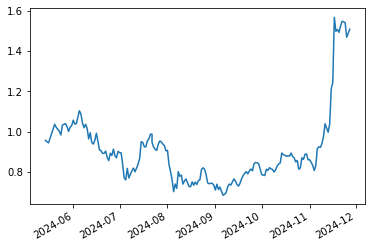

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'ENSUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT',
       'MANAUSDT', 'MKRUSDT', 'NEARUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT',
       'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT', 'SHIBUSDT',
       'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT',
       'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT',
       'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.001},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3119
TRXUSDT,0.2844
BNBUSDT,0.1597
XLMUSDT,0.0864
PEPEUSDT,0.0847
SUIUSDT,0.0493
RAYUSDT,0.0216
FDUSDUSDT,0.0010
USDCUSDT,0.0010
BONKUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.344717
BTCUSDT,0.300000
TRXUSDT,0.111971
XLMUSDT,0.091747
PEPEUSDT,0.065764
SUIUSDT,0.038082
BNBUSDT,0.034136
RAYUSDT,0.013584


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.648817
OMUSDT,0.220057
BTCUSDT,0.131126


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1655.565242,0.455869,0.220057,0.235812
BTCUSDT,839.193167,0.231076,0.131126,0.099950
SOLUSDT,422.347623,0.116296,0.000000,0.000000
JASMYUSDT,321.741481,0.088593,0.000000,0.000000
ETHUSDT,246.721614,0.067936,0.000000,0.000000
TRXUSDT,98.145524,0.027025,0.648817,-0.621792
BBUSDT,46.844267,0.012899,0.000000,0.000000
BNBUSDT,1.112734,0.000306,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1655.565242,0.455869,0.344717,0.111152
BTCUSDT,839.193167,0.231076,0.300000,-0.068924
SOLUSDT,422.347623,0.116296,0.000000,0.000000
JASMYUSDT,321.741481,0.088593,0.000000,0.000000
ETHUSDT,246.721614,0.067936,0.000000,0.000000
TRXUSDT,98.145524,0.027025,0.111971,-0.084946
BBUSDT,46.844267,0.012899,0.000000,0.000000
BNBUSDT,1.112734,0.000306,0.034136,-0.033830
PEPEUSDT,0.000005,0.000000,0.065764,-0.065764
XLMUSDT,0.000000,0.000000,0.091747,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

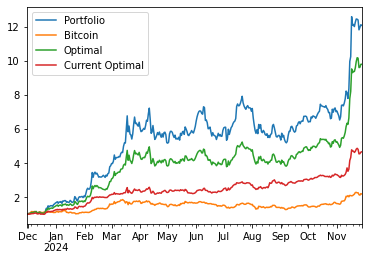

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

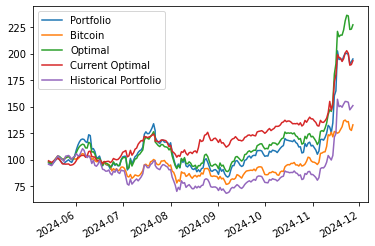

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-18,194.359080,125.761064,215.820230,196.177617,149.917217
2024-11-19,195.170898,128.302465,217.422027,195.718453,150.783228
2024-11-20,193.169862,131.019606,217.365709,192.584194,149.400069
2024-11-21,197.250553,136.504023,222.256532,195.150609,152.432825
2024-11-22,200.309943,137.299866,230.793182,200.521505,154.886223
2024-11-23,200.093412,135.596067,236.104007,202.698172,154.656666
2024-11-24,199.365305,135.911726,235.514273,200.184274,154.123725
2024-11-25,190.081089,128.947631,222.677716,189.028975,146.949156
2024-11-26,192.348238,127.490870,223.042678,189.625897,148.874744
2024-11-27,194.882216,132.783198,227.115414,193.243357,150.943684


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.595498
 dtype: float64,
 0.5962892865998707)

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.642582
 dtype: float64,
 0.6425818485828764)

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.722994
Bitcoin            0.438914
Optimal            0.596289
Current Optimal    0.407765
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.43524271711485746

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.049516,0.034136,0.004475,0.012346,0.000726,0.011619
BTCUSDT,0.356450,0.300000,0.035113,0.146361,0.048763,0.097599
OMUSDT,16.575326,0.344717,0.905041,0.663505,0.558211,0.105294
PEPEUSDT,0.322010,0.065764,0.020742,0.071164,0.019816,0.051348
RAYUSDT,0.059032,0.013584,0.003884,0.013369,0.000725,0.012644
SUIUSDT,0.078087,0.038082,0.006214,0.024229,0.003724,0.020505
TRXUSDT,0.091478,0.111971,0.010882,0.023519,0.003573,0.019947
XLMUSDT,0.163424,0.091747,0.013649,0.045506,0.013659,0.031847


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.512573,0.220057,0.382275,0.495765,0.396019,0.099746
BTCUSDT,0.053417,0.131126,0.096292,0.074735,0.021123,0.053612
TRXUSDT,0.350511,0.648817,0.521434,0.429500,0.335389,0.094111


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.060857,0.455446,0.686613,0.702833,0.585142,0.117692
BTCUSDT,0.092768,0.227723,0.145125,0.094225,0.021976,0.072249
SOLUSDT,0.042317,0.118812,0.072962,0.083190,0.014443,0.068747
JASMYUSDT,-0.003550,0.089109,0.038743,0.073307,0.017795,0.055512
ETHUSDT,0.005131,0.069307,0.033707,0.032524,0.003497,0.029027
TRXUSDT,0.016046,0.029703,0.020716,0.004250,0.000242,0.004007
BBUSDT,-0.005189,0.009901,0.002133,0.009671,0.000391,0.009280


# Value At Risk

## Historical

### Optimal Weights

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.048245152746513434, -0.06939499551448175)

### Current Weights

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04672074850970106, -0.06911647987437927)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

OMUSDT      -0.017721
BTCUSDT     -0.011668
SOLUSDT     -0.009057
JASMYUSDT   -0.007237
ETHUSDT      0.001090
TRXUSDT     -0.001852
BBUSDT      -0.000123
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.046569
Name: 2024-11-25 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.040363
BTCUSDT     -0.007771
SOLUSDT     -0.007840
JASMYUSDT   -0.007278
ETHUSDT     -0.002583
TRXUSDT     -0.000488
BBUSDT      -0.000744
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.067067
dtype: float64

## Parametric

### Optimal Weights

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06178513400423917, -0.079191459149975)

### Current Weights

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06658178591430247, -0.08533944069787235)

## Multivariate

### Optimal Weights

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05446214957666152, -0.07005042813386639)

### Current Weights

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06108103000312897, -0.07874714005038337)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.040165
BTCUSDT     -0.006751
SOLUSDT     -0.006166
JASMYUSDT   -0.005358
ETHUSDT     -0.002321
TRXUSDT     -0.000306
BBUSDT      -0.000671
Portfolio   -0.061738
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.053367799392427175, -0.06950166942863652)

### Current Weights

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06054771387257076, -0.07676040821735959)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.046227
BTCUSDT     -0.004266
SOLUSDT     -0.005283
JASMYUSDT   -0.003904
ETHUSDT     -0.001318
TRXUSDT     -0.000151
BBUSDT      -0.000613
Portfolio   -0.061763
dtype: float64

## Student Copula

### Optimal Weights

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05460488005953903, -0.07131034438485964)

### Current Weights

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06346705177572458, -0.08202941246347402)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.044570
BTCUSDT     -0.005438
SOLUSDT     -0.005098
JASMYUSDT   -0.005024
ETHUSDT     -0.001967
TRXUSDT     -0.000166
BBUSDT      -0.000735
Portfolio   -0.062998
dtype: float64

## Gumbel Copula

### Optimal Weights

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10260069505385268, -0.14359077297871686)

### Current Weights

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1106606355701165, -0.15934890183788564)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.106535
BTCUSDT     -0.001731
SOLUSDT     -0.001810
JASMYUSDT   -0.001958
ETHUSDT     -0.000006
TRXUSDT      0.000177
BBUSDT      -0.000253
Portfolio   -0.112116
dtype: float64

## Monte Carlo

### Optimal

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06237917771507915, -0.07850941499350134)

### Current Weights

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06710599219597889, -0.08392898687406705)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.048408
BTCUSDT     -0.006300
SOLUSDT     -0.005385
JASMYUSDT   -0.005209
ETHUSDT     -0.002021
TRXUSDT     -0.000259
BBUSDT      -0.000630
Portfolio   -0.068213
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.050778,-0.087815,-0.073821,-0.024235
2024-01-15,-0.050778,-0.087800,-0.072929,0.013189
2024-01-16,-0.050778,-0.087545,-0.071785,0.041045
2024-01-17,-0.050778,-0.088952,-0.075183,-0.023214
2024-01-18,-0.050778,-0.091253,-0.078410,-0.034849
...,...,...,...,...
2024-11-24,-0.027316,-0.111689,-0.086034,-0.002498
2024-11-25,-0.046898,-0.116530,-0.088411,-0.054504
2024-11-26,-0.046898,-0.115913,-0.093399,0.001639
2024-11-27,-0.046898,-0.114603,-0.090020,0.018260


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.034288,-0.084211,-0.080914,-0.016092
2024-05-29,-0.034288,-0.081645,-0.076419,-0.008674
2024-05-30,-0.034288,-0.070724,-0.068118,0.029950
2024-05-31,-0.034288,-0.071528,-0.064261,0.035729
2024-06-01,-0.034288,-0.074546,-0.065773,0.051226
...,...,...,...,...
2024-11-24,-0.040639,-0.180167,-0.143980,-0.003639
2024-11-25,-0.045746,-0.186961,-0.158980,-0.046569
2024-11-26,-0.045746,-0.186365,-0.155970,0.011927
2024-11-27,-0.045746,-0.184851,-0.153591,0.013174


<AxesSubplot:>

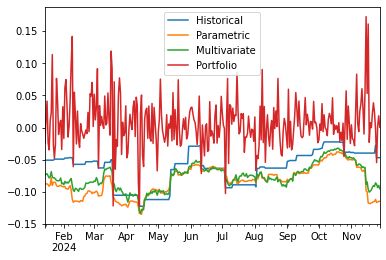

In [79]:
var_data.plot()

<AxesSubplot:>

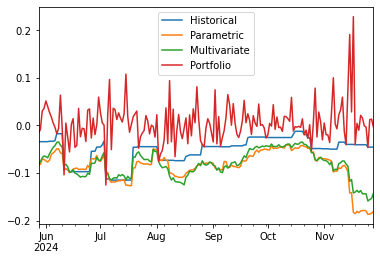

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.025,0.009375,0.0125
Kupiec Stat,5.118349,16.504303,13.377217
P-value,0.023674,0.000049,0.000255


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.07027,0.016216,0.010811
Kupiec Stat,1.42906,5.963605,8.66914
P-value,0.231918,0.014604,0.003236


# Principal Component Analysis

## Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77002309, 0.07366688, 0.06061899, 0.05090415, 0.04478689])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014920
ADAUSDT     0.015219
ALGOUSDT    0.016779
APTUSDT     0.015897
ARBUSDT     0.016767
              ...   
WBTCUSDT    0.009727
WLDUSDT     0.021922
XLMUSDT     0.012130
XRPUSDT     0.010064
XTZUSDT     0.015788
Name: PC1, Length: 63, dtype: float64

<AxesSubplot:>

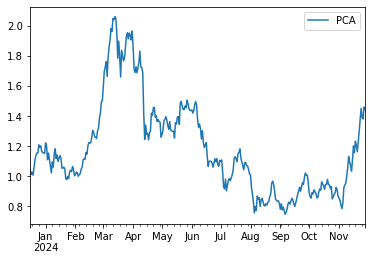

In [85]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

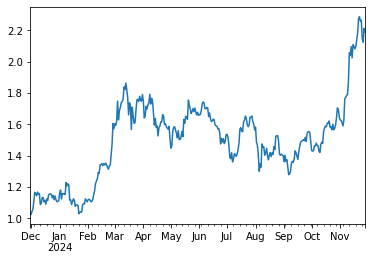

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.396482
WBETHUSDT    0.401714
ETHUSDT      0.401719
EGLDUSDT     0.408522
               ...   
WLDUSDT      1.096800
FLOKIUSDT    1.105210
BONKUSDT     1.107060
PEPEUSDT     1.137435
OMUSDT       1.518756
Length: 64, dtype: float64

<AxesSubplot:>

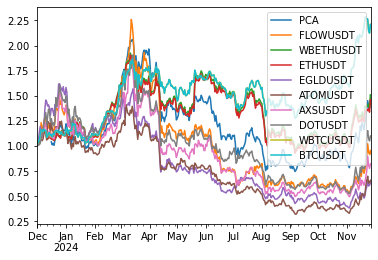

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

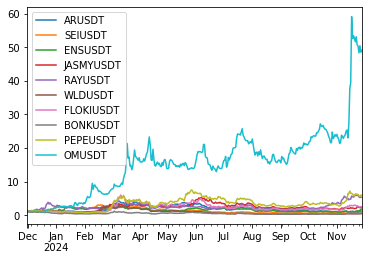

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59308796, 0.1710514 , 0.12590359, 0.07722996, 0.0327271 ])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.103581
BTCUSDT      0.066894
SOLUSDT      0.106821
JASMYUSDT    0.155622
ETHUSDT      0.089026
TRXUSDT      0.016785
BBUSDT       0.221388
BNBUSDT      0.066170
PEPEUSDT     0.173712
Name: PC1, dtype: float64

<AxesSubplot:>

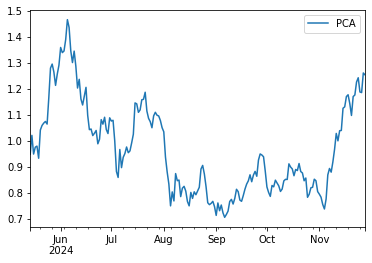

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

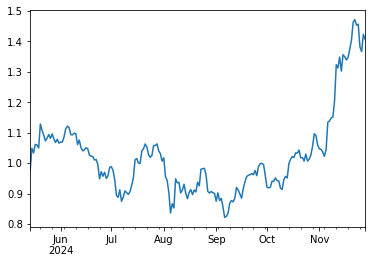

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.372054
ETHUSDT      0.374067
BTCUSDT      0.401880
BNBUSDT      0.410660
JASMYUSDT    0.517419
TRXUSDT      0.621471
PEPEUSDT     0.630118
BBUSDT       0.691043
OMUSDT       0.864044
dtype: float64

<AxesSubplot:>

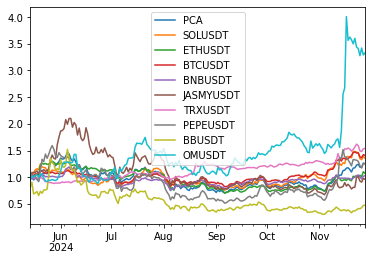

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.904110
BBUSDT       1.561771
JASMYUSDT    1.268430
SOLUSDT      1.148862
BTCUSDT      1.000000
ETHUSDT      0.947499
OMUSDT       0.886582
BNBUSDT      0.654400
TRXUSDT      0.270685
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.465224
SOLUSDT      1.096454
BTCUSDT      1.000000
BBUSDT       0.844358
ETHUSDT      0.782342
TRXUSDT      0.706763
JASMYUSDT    0.432319
BNBUSDT      0.404160
OMUSDT       0.074088
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [98]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451


In [99]:
results={}
window=14
days=90
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-09-13,0.000000,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.006347,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-09-27,0.280055,0.020386,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.032980,0.000000,0.0,0.0,0.0,0.0,0.087676,0.000000,0.314641,0.0
2024-10-11,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.466284,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-10-25,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009869,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-11-08,0.000000,0.415732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0
2024-11-22,0.000000,0.066801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.212029,0.028378,0.0
2024-11-28,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [100]:
rolling_optimization.iloc[-3].sort_values(ascending=False)

DOGEUSDT    0.453973
ADAUSDT     0.415732
RAYUSDT     0.108294
MKRUSDT     0.022001
SHIBUSDT    0.000000
              ...   
GALAUSDT    0.000000
GRTUSDT     0.000000
HBARUSDT    0.000000
ICPUSDT     0.000000
XTZUSDT     0.000000
Name: 2024-11-08 00:00:00, Length: 63, dtype: float64

<AxesSubplot:>

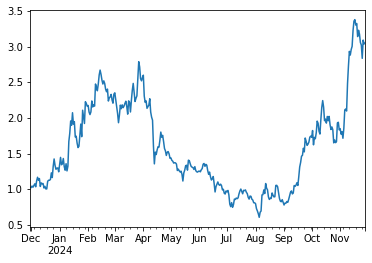

In [101]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()